<a href="https://www.kaggle.com/sanjayanbu/lstm-stock-market-prediction?scriptVersionId=89353982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Downloading required libraries

In [1]:
!pip install pandas-datareader

## Importing required libraries

In [2]:
import pandas_datareader as pdr
from kaggle_secrets import UserSecretsClient
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

## Retrieving the tiingo api key

In [3]:
user_secrets = UserSecretsClient()
tiingo_key = user_secrets.get_secret("tiingo-key")

## Retrieving the apple stock from tiingo

In [4]:
apple_stock_data = pdr.get_data_tiingo('AAPL', api_key=tiingo_key)

/opt/conda/lib/python3.7/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [5]:
apple_stock_data.head()

close      high       low     open  \
symbol date                                                             
AAPL   2017-03-06 00:00:00+00:00  139.34  139.7700  138.5959  139.365   
       2017-03-07 00:00:00+00:00  139.52  139.9800  138.7900  139.060   
       2017-03-08 00:00:00+00:00  139.00  139.8000  138.8200  138.950   
       2017-03-09 00:00:00+00:00  138.68  138.7900  137.0500  138.740   
       2017-03-10 00:00:00+00:00  139.14  139.3571  138.6400  139.250   

                                    volume   adjClose    adjHigh     adjLow  \
symbol date                                                                   
AAPL   2017-03-06 00:00:00+00:00  21750044  32.884773  32.986255  32.709163   
       2017-03-07 00:00:00+00:00  17446297  32.927254  33.035816  32.754971   
       2017-03-08 00:00:00+00:00  18707236  32.804532  32.993335  32.762051   
       2017-03-09 00:00:00+00:00  22155904  32.729011  32.754971  32.344324   
       2017-03-10 00:00:00+00:00  19612801  32.837572  32.888809  32.719570   

                                    adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                   
AAPL   2017-03-06 00:00:00+00:00  32.890673   87000176      0.0          1.0  
       2017-03-07 00:00:00+00:00  32.818692   69785188      0.0          1.0  
       2017-03-08 00:00:00+00:00  32.792732   74828944      0.0          1.0  
       2017-03-09 00:00:00+00:00  32.743171   88623616      0.0          1.0  
       2017-03-10 00:00:00+00:00  32.863533   78451204      0.0          1.0

## Data Preprocessing

In [6]:
apple_stock_data.to_csv("Apple_stock.csv")
input_data = pd.read_csv("Apple_stock.csv")
input_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-03-06 00:00:00+00:00,139.34,139.7700,138.5959,139.365,21750044,32.884773,32.986255,32.709163,32.890673,87000176,0.0,1.0
1,AAPL,2017-03-07 00:00:00+00:00,139.52,139.9800,138.7900,139.060,17446297,32.927254,33.035816,32.754971,32.818692,69785188,0.0,1.0
2,AAPL,2017-03-08 00:00:00+00:00,139.00,139.8000,138.8200,138.950,18707236,32.804532,32.993335,32.762051,32.792732,74828944,0.0,1.0
3,AAPL,2017-03-09 00:00:00+00:00,138.68,138.7900,137.0500,138.740,22155904,32.729011,32.754971,32.344324,32.743171,88623616,0.0,1.0
4,AAPL,2017-03-10 00:00:00+00:00,139.14,139.3571,138.6400,139.250,19612801,32.837572,32.888809,32.719570,32.863533,78451204,0.0,1.0


Text(0.5, 1.0, 'Closing Fluctuations')

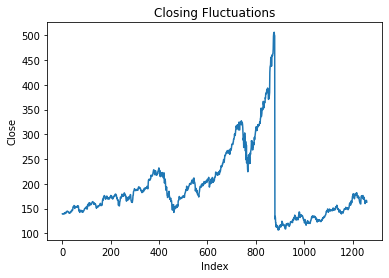

In [7]:
## we are going to plot only based on closing index
close_data = input_data.reset_index()['close']
fig, ax = plt.subplots()
plt.plot(close_data)
ax.set_xlabel('Index')
ax.set_ylabel('Close')
ax.set_title('Closing Fluctuations')

In [8]:
## LSTM is sensitive to data scaling
min_max_scaler = MinMaxScaler(feature_range=(0,1))
# Reshaping since fit_transform needs 2D-array
scaled_data = min_max_scaler.fit_transform(np.array(close_data).reshape(-1, 1))

In [9]:
## Since it is time series data, it may be present on the previous outputs, so, we need to split without affecting the order of the data
training_size = 0.60
test_size = 1 - training_size
cut_off_index = int(training_size * len(scaled_data))
train_data = scaled_data[:cut_off_index]
test_data = scaled_data[cut_off_index:]

In [10]:
def create_time_data(dataset, prev_inputs):
    x, y = [], []
    """
    prev_inputs -> 3
    x -> (t, t+1, t+2, t+3)
    y -> (t+4)
    """
    for i in range(len(dataset) - prev_inputs - 1):
        a = dataset[i: (i+prev_inputs), 0]
        x.append(a)
        y.append(dataset[(i+prev_inputs), 0])
    return np.array(x), np.array(y)

In [11]:
x_train, y_train = create_time_data(train_data, 100)
x_test, y_test = create_time_data(test_data, 100)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((655, 100), (403, 100), (655,), (403,))

In [12]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [13]:
x_train.shape

(655, 100, 1)

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2022-03-05 14:33:47.659895: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=64)

2022-03-05 14:33:48.779447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
11/11 [==============================] - 15s 586ms/step - loss: 0.0176 - val_loss: 0.0199
Epoch 2/15
11/11 [==============================] - 5s 431ms/step - loss: 0.0043 - val_loss: 0.0217
Epoch 3/15
11/11 [==============================] - 5s 428ms/step - loss: 0.0020 - val_loss: 0.0158
Epoch 4/15
11/11 [==============================] - 4s 404ms/step - loss: 0.0010 - val_loss: 0.0191
Epoch 5/15
11/11 [==============================] - 5s 406ms/step - loss: 7.0339e-04 - val_loss: 0.0212
Epoch 6/15
11/11 [==============================] - 4s 404ms/step - loss: 7.1022e-04 - val_loss: 0.0193
Epoch 7/15
11/11 [==============================] - 4s 397ms/step - loss: 6.5938e-04 - val_loss: 0.0170
Epoch 8/15
11/11 [==============================] - 5s 420ms/step - loss: 6.6493e-04 - val_loss: 0.0169
Epoch 9/15
11/11 [==============================] - 4s 402ms/step - loss: 6.2847e-04 - val_loss: 0.0180
Epoch 10/15
11/11 [==============================] - 4s 389ms/step - loss: 6.65

In [16]:
y_pred = model.predict(x_test)

## Evaluation

In [17]:
mean_squared_error(y_test.flatten(), y_pred.flatten())

0.014538418166987544

In [18]:
output = min_max_scaler.inverse_transform(y_pred)

In [19]:
output[:30]

array([[388.62473],
       [388.19272],
       [387.6171 ],
       [387.54758],
       [388.39056],
       [390.3185 ],
       [393.3268 ],
       [397.47855],
       [402.472  ],
       [408.10098],
       [413.917  ],
       [419.7965 ],
       [425.66736],
       [431.39972],
       [436.85065],
       [441.95523],
       [446.6478 ],
       [451.01523],
       [455.3975 ],
       [459.96326],
       [464.6719 ],
       [469.53204],
       [474.3709 ],
       [479.0355 ],
       [478.1802 ],
       [470.3844 ],
       [455.47   ],
       [434.08875],
       [407.52393],
       [377.21933]], dtype=float32)